# Bayesian implementation of forced-response model in PyMC3

### Based on Blair et al. 2015


In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pymc as pm

# Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

The first step is to simulate known data from which to test the model. According to Blair *et al.*, the forced-response model involves a randomization device that forces a yes with probability $p_{fyes}$, a no with probability $p_{fno}$, and an assumed truthful answer with probability $p_{truthful}=1-p_{fyes}-p_{fno}$. So the first step is to assign these probabilities: 

In [2]:
# Dice randomizer setup in Blair et al.
p_fyes = 1/6
p_fno = 1/6
p_truth = 1-p_fyes-p_fno
randomizer = np.array([p_fyes,p_fno,p_truth])

# True underlying probability of yes
p_interest = 0.34

# Number of observations
nobs = 250

In Blair's description, they use $Z_i$ to represent the true (unobserved, latent) distribution of yes ($=1$) and no ($=0$) in the population. So we'll first simulate this from the data:

In [3]:
# Latent truth
Zi = np.random.binomial(n=1, p=p_interest, size=nobs)
Zi

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

The next step is to transform $Z_i$ into fake observations using the known randomizer probabilities:

In [4]:
# Create forced no and yes array
randp = np.random.multinomial(1, randomizer, size=nobs)
Ri = np.array([np.array([1,-1,0])[x==1] for x in randp]).reshape(1,nobs)[0]
Ri

array([ 1,  0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0, -1,  1,  0,
        0,  0,  0, -1,  1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,
        0,  0, -1, -1, -1,  0,  0,  0, -1,  0,  1,  1,  0,  0,  0,  0,  0,
        0, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  1, -1,  1, -1,
        1,  1,  0,  0, -1,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1, -1,  0,  0, -1,  0,  1,  1,  0,  1, -1,  0,  0,  0,
        1, -1,  0,  0,  0, -1,  1,  0,  1,  1,  1,  0,  0,  0, -1, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0, -1, -1,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,  0,  1,  0,  1,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0, -1,  0,  1,  1,  0,  0,  0,  0,
        1,  1,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0, -1,  0,  0,  0,  1,
        1, -1,  0,  0,  0

In [5]:
# Observed data
Yobs = 1*((Zi+Ri)>0)
Yobs

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

Now that we have known data with 1/6 probabilities of false yes and no responses, we can build a statistical model to see if we can recover the true probability of yes.

In [6]:
# True probability of yes
P_yes = pm.Beta('P_yes',alpha=1,beta=1)

# Mean model
p_mu = pm.Lambda('p_mu', lambda p=P_yes: p_truth*P_yes+p_fyes)

# Likelihood
Yi = pm.Bernoulli('Yi', p=p_mu, value=Yobs, observed=True)

In [7]:
M = pm.MCMC(locals())

In [8]:
M.sample(10000,9000)
M.sample(10000,9000)

 [-----------------100%-----------------] 10000 of 10000 complete in 3.5 sec

Plotting P_yes


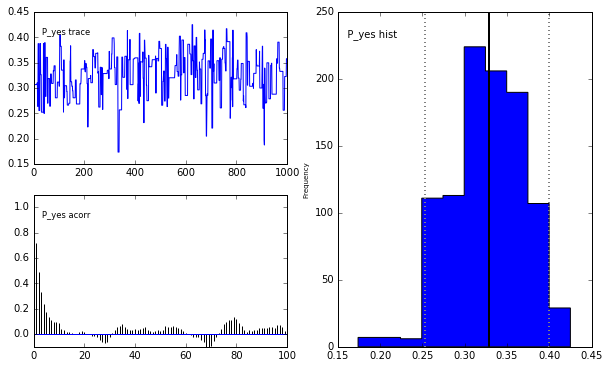

In [9]:
pm.Matplot.plot(P_yes)

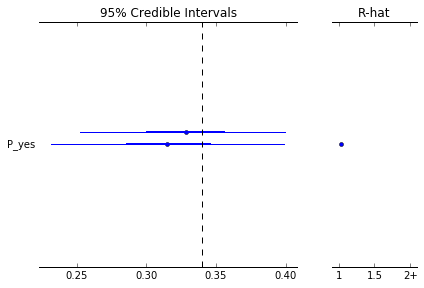

In [10]:
pm.Matplot.summary_plot(P_yes, vline_pos=p_interest)

So from this we have a model framwork for analyzing a forced response design - covariates in a linear model can be readily added to 'P_yes' using a logit link.